# Solving a mixed Neumann-Dirichlet Problem

### Background

With Bempp, it is possible to define operators only on segments of a given domain. This makes it possible to solve mixed Neumann-Dirichlet problems. In this tutorial, we solve the Laplace equation inside the unit cube with unit Dirichlet boundary conditions on two sides and unit Neumann boundary conditions on the other four sides.

Denote by $\Gamma_D$ the part of the boundary that holds the Dirichlet boundary conditions and by $\Gamma_N$ the boundary part that holds the Neumann boundary conditions. We denote by $t\in\Gamma_D$ the unknown Neumann data and by $u\in\Gamma_N$ the unknown Dirichlet data. The given Dirichlet data on $\Gamma_D$ is denoted by $g_D$ and the given Neumann data on $\Gamma_N$ is denoted by $g_N$.

From Green's representation theorem it follows that
$$
\begin{align}
\left[\mathsf{V}t\right] (\mathbf{x}) - \left[\mathsf{K}u\right] (\mathbf{x}) &= \left[\tfrac{1}{2}\mathsf{Id} + \mathsf{K}\right]g_D(\mathbf{x}) - \mathsf{V}g_N(\mathbf{x}),\quad \mathbf{x}\in\Gamma_D\\
\left[\mathsf{W}u\right] (\mathbf{x}) + \left[\mathsf{K}'t\right] (\mathbf{x}) &=\left[\tfrac{1}{2}\mathsf{Id} - \mathsf{K}'\right]g_N(\mathbf{x}) - \mathsf{W}g_D(\mathbf{x}),\quad \mathbf{x}\in\Gamma_N
\end{align}
$$
Here (as usual) $\mathsf{V}$, $\mathsf{K}$, $\mathsf{K}'$, $\mathsf{W}$ are the single layer, double layer, adjoint double layer and hypersingular <a href='https://bempp.com/2017/07/11/available_operators/'>boundary operators</a>.

The difficulty in the implementation is the definition of the discrete function spaces and the treatment of degrees of freedom (dofs) that lie on the interface between $\Gamma_N$ and $\Gamma_D$. In the following, we will go through the implementation and point out how to correctly define all spaces involved.

### Implementation

We start with the usual imports and set the plotting backend to Jupyter Notebook.

In [1]:
import bempp.api
import numpy as np

We now define the domain. We use a standard unit cube. In the corresponding function all sides of the cube are already associated with different domain indices. We associate the indices 1 and 3 with the Dirichlet boundary and the other indices with the neumann boundary.

In [2]:
grid = bempp.api.shapes.cube()
dirichlet_segments = [1, 3]
neumann_segments = [2, 4, 5, 6]

We can now define the spaces. For the Neumann data, we use discontinuous polynomial basis functions of order 1. For the Dirichlet data, we use continuous basis functions of local polynomial order 2.

We need global spaces for the Dirichlet and Neumann data and suitable spaces on the segments. The space definitions are as follows:

* The ``neumann_space_dirichlet_segment`` space holds the unknown Neumann data $t$ on $\Gamma_D$.

* The ``neumann_space_neumann_segment`` space is defined on $\Gamma_N$ and holds the Neumann data on this segment.

* The ``dirichlet_space_dirichlet_segment`` space is a space of continuous basis functions that holds the Dirichlet data on $\Gamma_D$. Basis functions are allowed to extend into the elements adjacent to $\Gamma_D$. We hence set the parameter ``include_boundary_dofs`` to true. This ensures that we include dofs on the boundary of the segment, and to ensure that the basis functions extend continuously into the complement of the segment we additionally set ``ensure_global_continuity`` to true.

* The ``dirichlet_space_neumann_segment`` is defined similarly to the ``dirichlet_space_dirichlet_segment`` but on the open segment $\Gamma_N$. Hence, we require that ``include_boundary_dofs`` is false, which is the default.

In [3]:
global_neumann_space = bempp.api.function_space(grid, "DP", 0)
global_dirichlet_space = bempp.api.function_space(grid, "P", 1)

neumann_space_dirichlet_segment = bempp.api.function_space(
    grid, "DP", 0, segments=dirichlet_segments)

neumann_space_neumann_segment = bempp.api.function_space(
    grid, "DP", 0, segments=neumann_segments)

dirichlet_space_dirichlet_segment = bempp.api.function_space(
    grid, "P", 1, segments=dirichlet_segments, include_boundary_dofs=True,
    ensure_global_continuity=True)

dirichlet_space_neumann_segment = bempp.api.function_space(
    grid, "P", 1, segments=neumann_segments)

dual_dirichlet_space = bempp.api.function_space(
    grid, "P", 1, segments=dirichlet_segments,
    include_boundary_dofs=True)

In the following, we define all operators on the corresponding spaces and the overall blocked operator.

In [4]:
slp_DD = bempp.api.operators.boundary.laplace.single_layer(
    neumann_space_dirichlet_segment,
    dirichlet_space_dirichlet_segment,
    neumann_space_dirichlet_segment)

dlp_DN = bempp.api.operators.boundary.laplace.double_layer(
    dirichlet_space_neumann_segment,
    dirichlet_space_dirichlet_segment,
    neumann_space_dirichlet_segment)

adlp_ND = bempp.api.operators.boundary.laplace.adjoint_double_layer(
    neumann_space_dirichlet_segment,
    neumann_space_neumann_segment,
    dirichlet_space_neumann_segment)

hyp_NN = bempp.api.operators.boundary.laplace.hypersingular(
    dirichlet_space_neumann_segment,
    neumann_space_neumann_segment,
    dirichlet_space_neumann_segment)

slp_DN = bempp.api.operators.boundary.laplace.single_layer(
    neumann_space_neumann_segment,
    dirichlet_space_dirichlet_segment,
    neumann_space_dirichlet_segment)

dlp_DD = bempp.api.operators.boundary.laplace.double_layer(
    dirichlet_space_dirichlet_segment,
    dirichlet_space_dirichlet_segment,
    neumann_space_dirichlet_segment)

id_DD = bempp.api.operators.boundary.sparse.identity(
    dirichlet_space_dirichlet_segment,
    dirichlet_space_dirichlet_segment,
    neumann_space_dirichlet_segment)

adlp_NN = bempp.api.operators.boundary.laplace.adjoint_double_layer(
    neumann_space_neumann_segment,
    neumann_space_neumann_segment,
    dirichlet_space_neumann_segment)

id_NN = bempp.api.operators.boundary.sparse.identity(
    neumann_space_neumann_segment,
    neumann_space_neumann_segment,
    dirichlet_space_neumann_segment)

hyp_ND = bempp.api.operators.boundary.laplace.hypersingular(
    dirichlet_space_dirichlet_segment,
    neumann_space_neumann_segment,
    dirichlet_space_neumann_segment)

blocked = bempp.api.BlockedOperator(2, 2)

blocked[0, 0] = slp_DD
blocked[0, 1] = -dlp_DN
blocked[1, 0] = adlp_ND
blocked[1, 1] = hyp_NN

Next, we define the functions of the Dirichlet and Neumann data and their discretisations on the corresponding segments.

In [5]:
@bempp.api.real_callable
def dirichlet_data(x, n, domain_index, res):
    res[0] = 1
 
@bempp.api.real_callable
def neumann_data(x, n, domain_index, res):
    res[0] = 1

dirichlet_grid_fun = bempp.api.GridFunction(
    dirichlet_space_dirichlet_segment,
    fun=dirichlet_data,
    dual_space=dual_dirichlet_space)

neumann_grid_fun = bempp.api.GridFunction(
    neumann_space_neumann_segment,
    fun=neumann_data,
    dual_space=dirichlet_space_neumann_segment)

rhs_fun1 = (.5 * id_DD + dlp_DD) * dirichlet_grid_fun \
           - slp_DN * neumann_grid_fun
rhs_fun2 = - hyp_ND * dirichlet_grid_fun \
           + (.5 * id_NN - adlp_NN) * neumann_grid_fun

We can now discretise and solve the blocked operator system. We solve without preconditioner. This would cause problems if we were to further increase the degree of the basis functions. Note that Bempp automatically handles the block structure correctly. We have a $2\times 2$ system of operators, hand over as right-hand side two grid functions, and are returned two grid functions as solution.

In [6]:
(neumann_solution, dirichlet_solution), _ = bempp.api.linalg.gmres(blocked, [rhs_fun1, rhs_fun2])

We want to recombine the computed Dirichlet and Neumann data with the corresponding known data in order to get Dirichlet and Neumann grid functions defined on the whole grid. To achieve this we define identity operators from $\Gamma_N$ and $\Gamma_D$ into the global Dirichlet and Neumann spaces.

In [7]:
neumann_imbedding_dirichlet_segment = \
    bempp.api.operators.boundary.sparse.identity(
        neumann_space_dirichlet_segment,
        global_neumann_space,
        global_neumann_space)

neumann_imbedding_neumann_segment = \
    bempp.api.operators.boundary.sparse.identity(
        neumann_space_neumann_segment,
        global_neumann_space,
        global_neumann_space)

dirichlet_imbedding_dirichlet_segment = \
    bempp.api.operators.boundary.sparse.identity(
        dirichlet_space_dirichlet_segment,
        global_dirichlet_space,
        global_dirichlet_space)

dirichlet_imbedding_neumann_segment = \
    bempp.api.operators.boundary.sparse.identity(
        dirichlet_space_neumann_segment,
        global_dirichlet_space,
        global_dirichlet_space)

dirichlet = (dirichlet_imbedding_dirichlet_segment * dirichlet_grid_fun +
             dirichlet_imbedding_neumann_segment * dirichlet_solution)

neumann = (neumann_imbedding_neumann_segment * neumann_grid_fun +
           neumann_imbedding_dirichlet_segment * neumann_solution)

Finally, we export the solution.

In [8]:
bempp.api.export('mixed_dirichlet_neumann_laplace_solution.msh', grid_function=dirichlet)

It should look as follows.

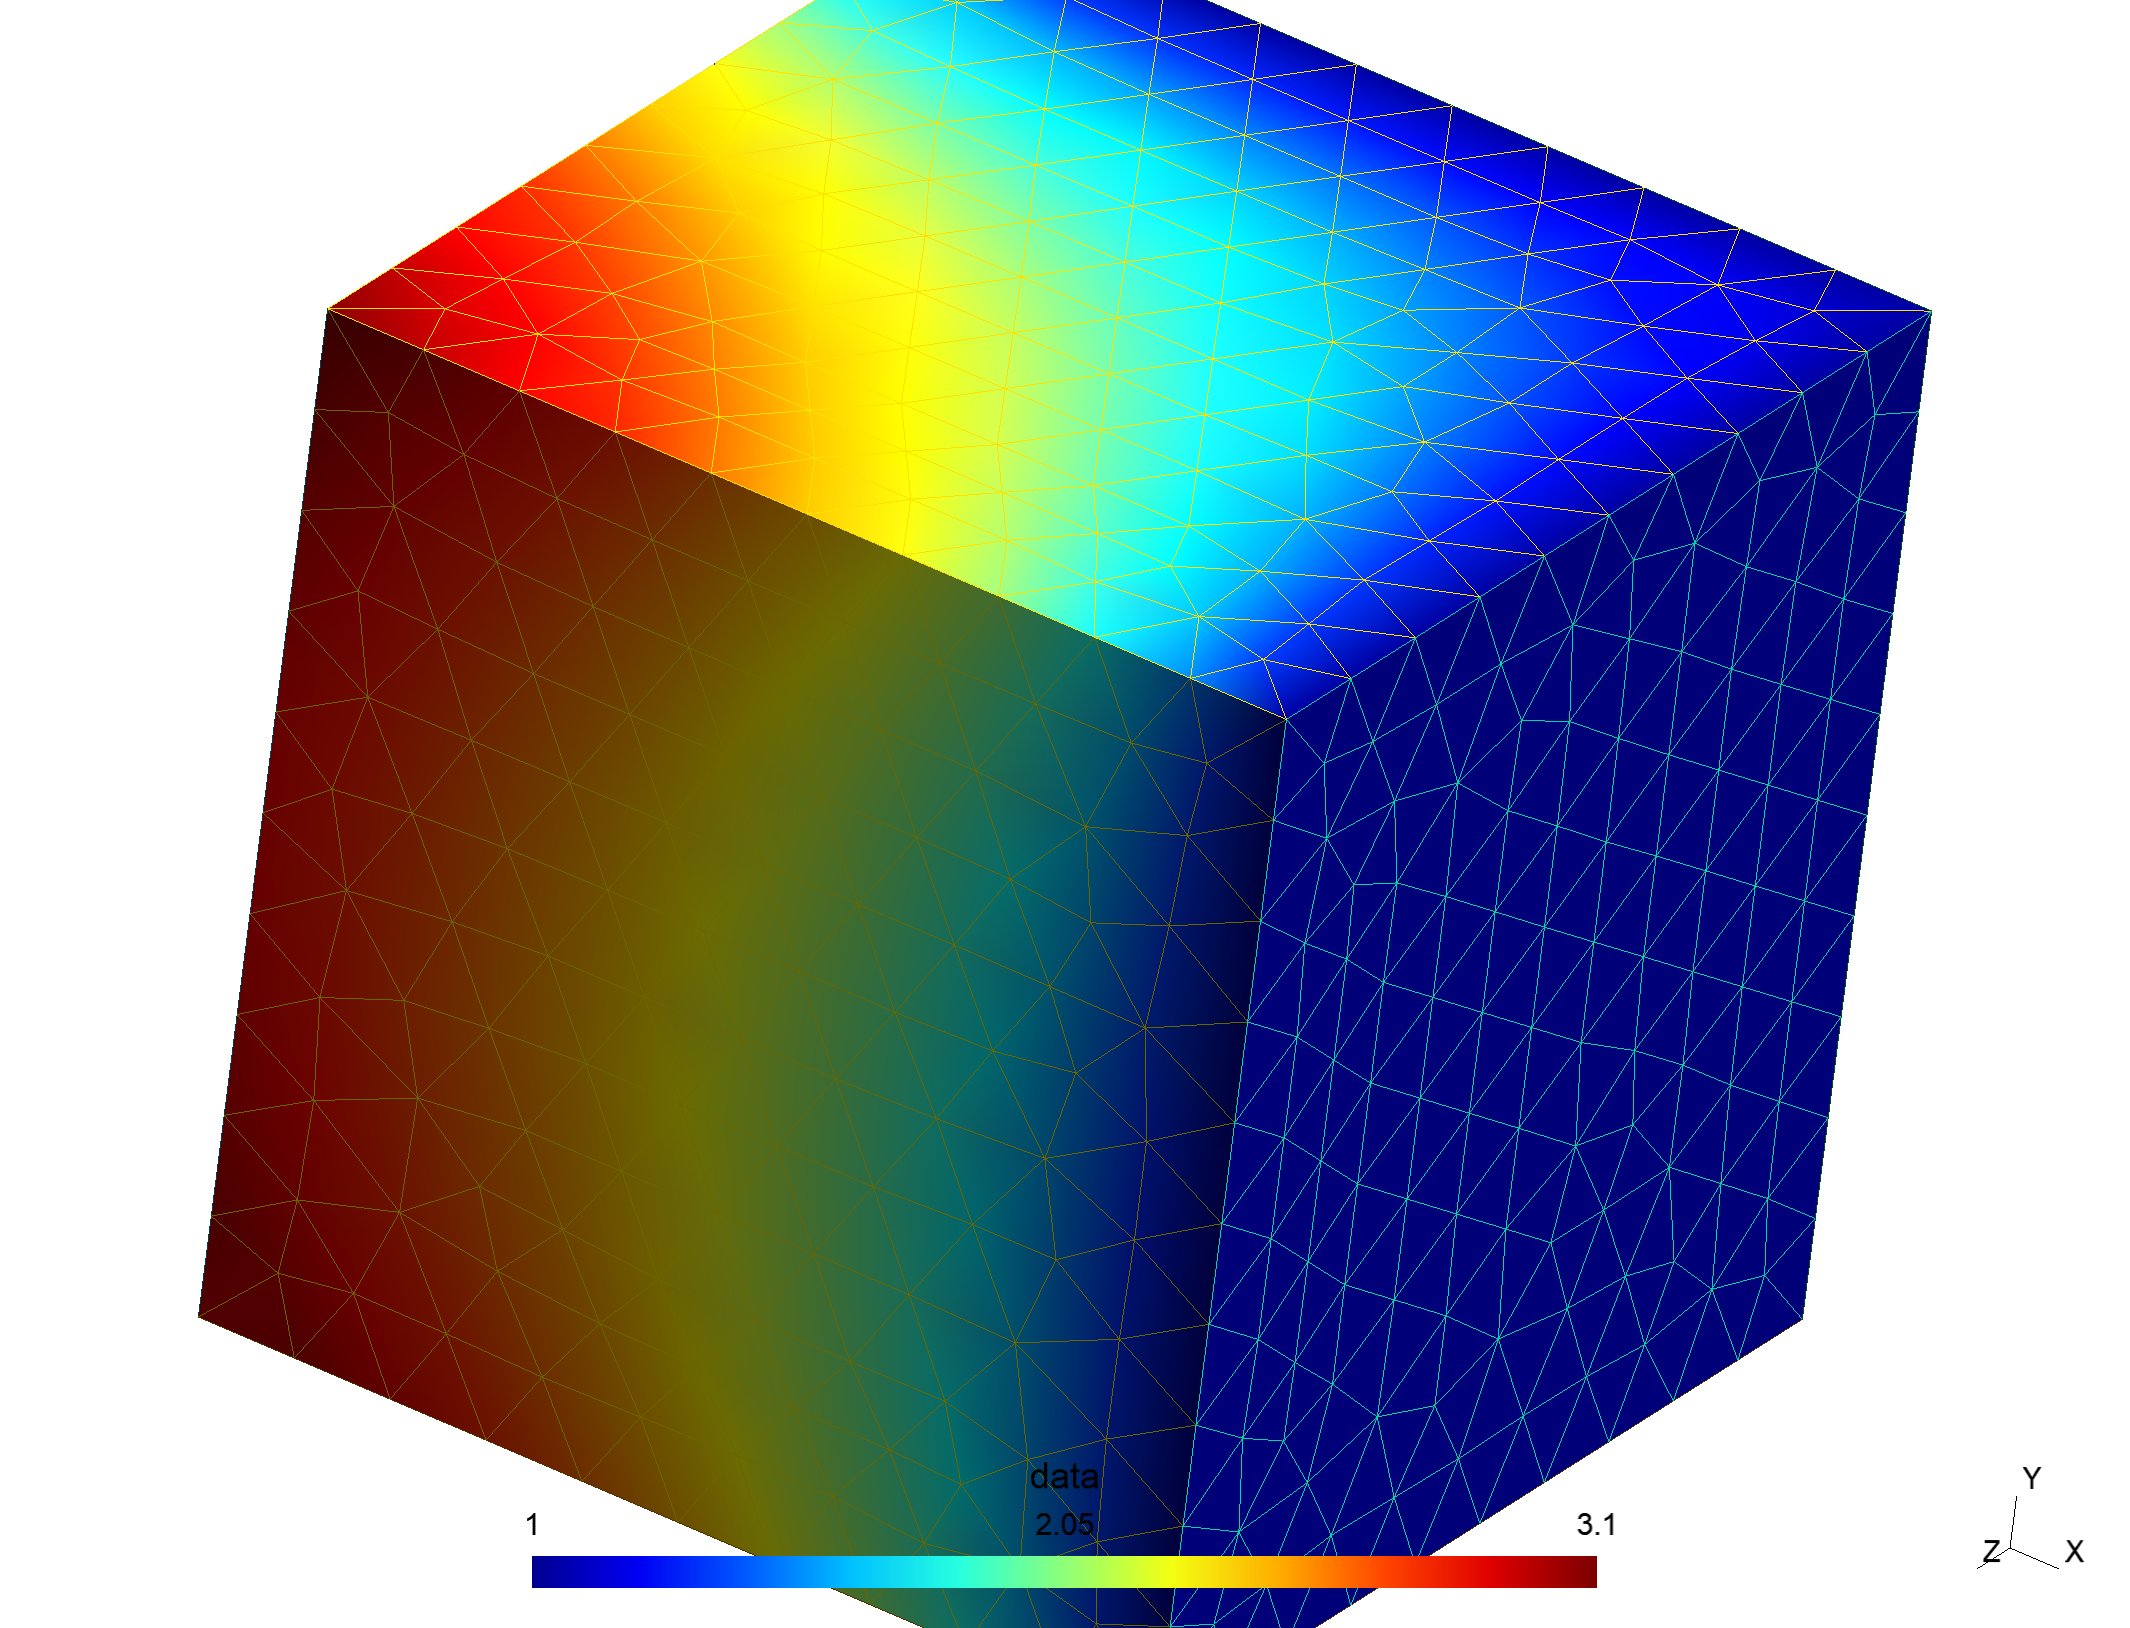

In [9]:
from IPython.display import Image
Image("mixed_dirichlet_neumann_laplace_solution.png")